## Training an MLIP and its LLPR module

Now, we will walk you through a process where you train an MLIP, then also the LLPR module associated with it for uncertainty quantification. Let's first generate a set of structures and obtain their reference energies:

In [7]:
from metatomic.torch.ase_calculator import MetatomicCalculator
from metatomic.torch import ModelOutput
import ase.io
import matplotlib.pyplot as plt
import numpy as np

100%|██████████| 100/100 [00:05<00:00, 18.64it/s]


Predicted forces shape: (9000, 3)
Predicted NC forces shape: (9000, 3)
True forces shape: (9000, 3)
Uncertainties shape: (9000,)
0.8974411558916402


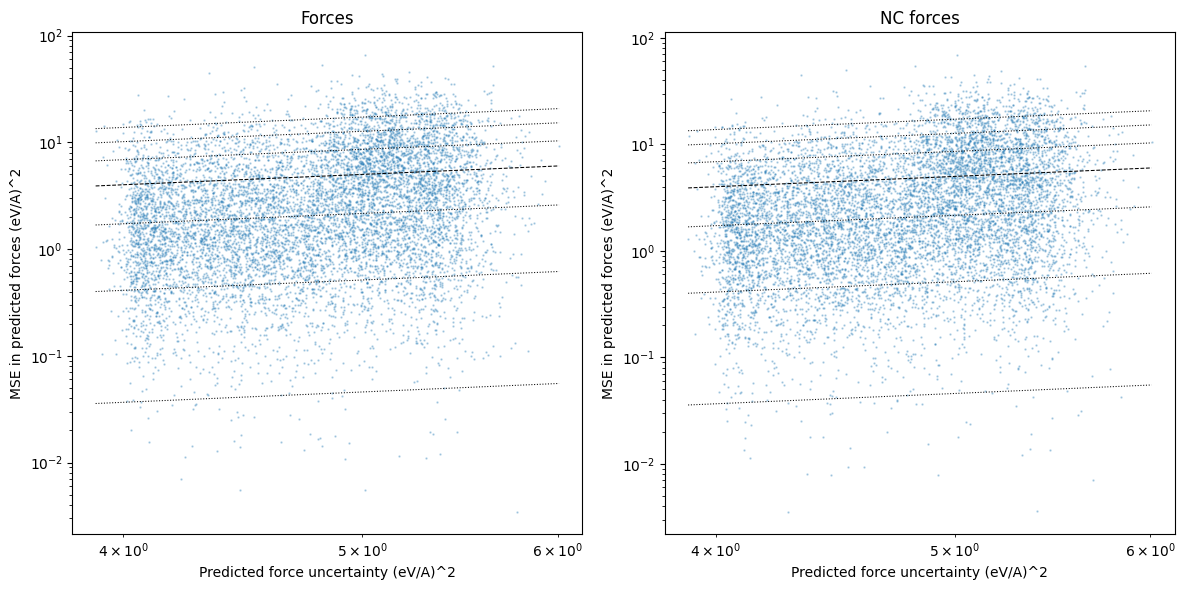

In [ ]:

# Load the structures
structures = ase.io.read("ethanol_train_0.xyz", ":")
calc = MetatomicCalculator("model-llpr.pt")

# Split structures into batches of 10
batch_size = 10
batches = [structures[i:i + batch_size] for i in range(0, len(structures), batch_size)]

predicted_forces = []
predicted_forces_nc = []
true_forces = []
uncertainties = []
model_outputs = {
    "non_conservative_forces": ModelOutput(per_atom=True),
    "mtt::aux::non_conservative_forces_uncertainty": ModelOutput(per_atom=True),
}
import tqdm
for batch in tqdm.tqdm(batches):
    true_forces.append(np.concatenate([structure.get_forces() for structure in batch]))
    forces = calc.compute_energy(batch, compute_forces_and_stresses=True)["forces"]
    forces = np.concatenate(forces)
    results = calc.run_model(batch, model_outputs)
    non_conservative_forces = results["non_conservative_forces"].block().values.squeeze(-1).detach().cpu().numpy()
    u = results["mtt::aux::non_conservative_forces_uncertainty"].block().values.squeeze(-1).detach().cpu().numpy()
    predicted_forces.append(forces)
    predicted_forces_nc.append(non_conservative_forces)
    uncertainties.append(u**2)
predicted_forces = np.concatenate(predicted_forces)
predicted_forces_nc = np.concatenate(predicted_forces_nc)
true_forces = np.concatenate(true_forces)
uncertainties = np.concatenate(uncertainties)

print("Predicted forces shape:", predicted_forces.shape)
print("Predicted NC forces shape:", predicted_forces_nc.shape)
print("True forces shape:", true_forces.shape)
print("Uncertainties shape:", uncertainties.shape)

errors = np.sum((predicted_forces - true_forces)**2, axis=1)
errors_nc = np.sum((predicted_forces_nc - true_forces)**2, axis=1)

print(np.mean(errors_nc/uncertainties))

quantile_lines = [0.00916, 0.10256, 0.4309805, 1.71796, 2.5348, 3.44388]
min_val_x = np.min(uncertainties)
max_val_x = np.max(uncertainties)
min_val_y = np.min(errors)
max_val_y = np.max(errors)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# Plot using normal uncertainties
ax[0].plot([min_val_x, max_val_x], [min_val_x, max_val_x], "k--", lw=0.75)
for factor in quantile_lines:
    ax[0].plot([min_val_x, max_val_x], [factor * min_val_x, factor * max_val_x], "k:", lw=0.75)
ax[0].scatter(uncertainties, errors, s=0.5, alpha=0.3)
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlabel("Predicted NC force uncertainty (eV/A)^2")
ax[0].set_ylabel("MSE in predicted forces (eV/A)^2")
ax[0].set_title("Forces")
# Plot using ensemble uncertainties
ax[1].plot([min_val_x, max_val_x], [min_val_x, max_val_x], "k--", lw=0.75)
for factor in quantile_lines:
    ax[1].plot([min_val_x, max_val_x], [factor * min_val_x, factor * max_val_x], "k:", lw=0.75)
ax[1].scatter(uncertainties, errors_nc, s=0.5, alpha=0.3)
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xlabel("Predicted NC force uncertainty (eV/A)^2")
ax[1].set_ylabel("MSE in predicted NC forces (eV/A)^2")
ax[1].set_title("NC forces")

plt.tight_layout()
plt.show()


The errors roughly follow the distribution predicted by the uncertainties of our model. To get better agreement, if your computer can handle it, you can try to train for 500 epochs instead of 100.